# Scaling experiments

Here we try to plot figures of scaling curves for MTL models and STL models and their PUB results. It can reflect how models perform for temporal and spatial generalization when the number of trained basins increases.

When the number of basins is small, the choice of basins may be biased. So we randomly select basins from the whole dataset for many times and calculate the mean/median metrics as the final result.

We can see the difference between MTL and STL models.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

# Get the current directory of the notebook
notebook_dir = os.path.abspath("")
# Get the parent directory of the notebook directory
project_dir = os.path.dirname(notebook_dir)
# import the module using a relative path
sys.path.append(project_dir)
import definitions
from scripts.streamflow_utils import get_json_file
from hydromtl.models.trainer import stat_result
from hydromtl.utils import hydro_constant
from hydromtl.visual.plot_stat import plot_simple_lines


Please Check your directory:
ROOT_DIR of the repo:  /mnt/sdc/owen/code/HydroMTL
DATA_SOURCE_DIR of the repo:  /mnt/data/owen411/data
RESULT_DIR of the repo:  /mnt/sdc/owen/code/HydroMTL/results


/mnt/data/owen411/program/miniconda3/envs/MTL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x_percents = [5, 10, 20, 25, 33, 50, 66, 75, 80, 90, 95]


There are multiple sub-experiments in each x_percent setting. Read them all and calcuate the mean/median value of all sub-experiments as the final result.

First, get the list of all experiments.

In [3]:
mtl_scale_exps = [
    "expscalemtlpercent" + str(x_percents[i]).zfill(3) for i in range(len(x_percents))
]
et_scale_exps = [
    "expscalestletpercent" + str(x_percents[i]).zfill(3) for i in range(len(x_percents))
]
q_scale_exps = [
    "expscalestlqpercent" + str(x_percents[i]).zfill(3) for i in range(len(x_percents))
]


Then, for each experiment, get the list of all sub-experiments.

## 1. Temporal generalization sub-experiments

In [4]:
all_mtl_scale_temporal_exps=[]
all_et_scale_temporal_exps=[]
all_q_scale_temporal_exps=[]
for i in range(len(mtl_scale_exps)):
    x_percent = x_percents[i]
    if x_percent < 50:
        split_num = int(1 / (x_percent / 100))
    else:
        split_num = round(1 / (1 - x_percent / 100))
    mtl_scale_temporal_exps = [
        mtl_scale_exps[i] + str(j + 1).zfill(2) for j in range(split_num)
    ]
    et_scale_temporal_exps = [
        et_scale_exps[i] + str(j + 1).zfill(2) for j in range(split_num)
    ]
    q_scale_temporal_exps = [
        q_scale_exps[i] + str(j + 1).zfill(2) for j in range(split_num)
    ]
    all_mtl_scale_temporal_exps.append(mtl_scale_temporal_exps)
    all_et_scale_temporal_exps.append(et_scale_temporal_exps)
    all_q_scale_temporal_exps.append(q_scale_temporal_exps)

Function to read metric of each sub-experiment:

In [5]:
import pickle


def read_metric_of_all_sub_exps(
    scale_exps,
    var_idx=0,
    metric="NSE",
    var_names=[
        hydro_constant.streamflow.name,
        hydro_constant.evapotranspiration.name,
    ],
    var_units=["ft3/s", "mm/day"],
    save_file="list.pkl",
):
    # Check if the saved list file exists
    if os.path.exists(save_file):
        # Load the list from the file
        with open(save_file, "rb") as file:
            ind_all_lst = pickle.load(file)
    else:
        ind_all_lst = []
        for i in range(len(scale_exps)):
            # for each sub-experiment
            ind_lst = []
            for j in range(len(scale_exps[i])):
                cfg_dir = os.path.join(
                    definitions.RESULT_DIR,
                    "camels",
                    scale_exps[i][j],
                )
                try:
                    cfg_data = get_json_file(cfg_dir)
                    inds_df_tmp, _, _ = stat_result(
                        cfg_data["data_params"]["test_path"],
                        cfg_data["evaluate_params"]["test_epoch"],
                        fill_nan=cfg_data["evaluate_params"]["fill_nan"],
                        return_value=True,
                        var_unit=var_units,
                        var_name=var_names,
                    )
                except:
                    continue
                ind_lst.append(inds_df_tmp[var_idx][metric].values)
            ind_all_lst.append(ind_lst)
        with open(save_file, "wb") as file:
            pickle.dump(ind_all_lst, file)
    return ind_all_lst


Then, we can read results of all the sub-experiments

For streamflow of MTL exps:

In [6]:
mtlq_temporal_metric_lst = read_metric_of_all_sub_exps(
    all_mtl_scale_temporal_exps, save_file="mtlq_temporal_metric_lst.pkl"
)


For streamflow of STL exps:

In [7]:
stlq_temporal_metric_lst = read_metric_of_all_sub_exps(
    all_q_scale_temporal_exps, save_file="stlq_temporal_metric_lst.pkl"
)


For evapotranspiration of MTL exps:

In [8]:
mtlet_temporal_metric_lst = read_metric_of_all_sub_exps(
    all_mtl_scale_temporal_exps,
    var_idx=1,
    save_file="mtlet_temporal_metric_lst.pkl",
)


For evapotranspiration of STL exps:

In [9]:
stlet_temporal_metric_lst = read_metric_of_all_sub_exps(
    all_et_scale_temporal_exps,
    var_idx=1,
    save_file="stlet_temporal_metric_lst.pkl",
)


## 2. Spatial generalization sub-experiments

In [10]:
all_mtl_scale_spatial_exps = []
all_q_scale_spatial_exps = []
all_et_scale_spatial_exps = []
for i in range(len(mtl_scale_exps)):
    x_percent = x_percents[i]
    if x_percent < 50:
        split_num = int(1 / (x_percent / 100))
    else:
        split_num = round(1 / (1 - x_percent / 100))
    mtl_scale_spatial_exps = [
        mtl_scale_exps[i] + str(j + 1).zfill(2) + "0" for j in range(split_num)
    ]
    q_scale_spatial_exps = [
        q_scale_exps[i] + str(j + 1).zfill(2) + "0" for j in range(split_num)
    ]
    et_scale_spatial_exps = [
        et_scale_exps[i] + str(j + 1).zfill(2) + "0" for j in range(split_num)
    ]
    all_mtl_scale_spatial_exps.append(mtl_scale_spatial_exps)
    all_q_scale_spatial_exps.append(q_scale_spatial_exps)
    all_et_scale_spatial_exps.append(et_scale_spatial_exps)

Read metrics:

In [11]:
mtlq_spatial_metric_lst = read_metric_of_all_sub_exps(
    all_mtl_scale_spatial_exps, save_file="mtlq_spatial_metric_lst.pkl"
)


In [12]:
stlq_spatial_metric_lst = read_metric_of_all_sub_exps(
    all_q_scale_spatial_exps, save_file="stlq_spatial_metric_lst.pkl"
)

In [13]:
mtlet_spatial_metric_lst = read_metric_of_all_sub_exps(
    all_mtl_scale_spatial_exps,
    var_idx=1,
    save_file="mtlet_spatial_metric_lst.pkl",
)

In [14]:
stlet_spatial_metric_lst = read_metric_of_all_sub_exps(
    all_et_scale_spatial_exps,
    var_idx=1,
    save_file="stlet_spatial_metric_lst.pkl",
)

## Plots

Next, we can plot the scaling curves.

Temporal exps are plotted in one figure and spatial exps are plotted in another figure.

In [15]:
def mean_of_medians(metric_lst):
    medians = []
    for arr_lst in metric_lst:
        a_median = []
        for arr in arr_lst:
            a_median.append(np.median(arr))
        medians.append(np.mean(a_median))
    return medians

In [16]:
xlabel = "Percent basin used for training"
ylabel = "Median NSE"
figure_dir = os.path.join(definitions.RESULT_DIR, "figures")

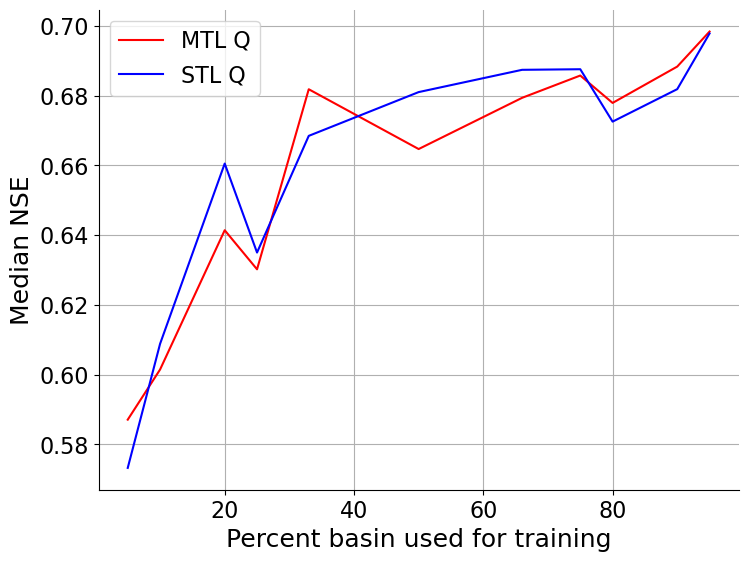

In [17]:
mtlq_temporal_medians = mean_of_medians(mtlq_temporal_metric_lst)
stlq_temporal_medians = mean_of_medians(stlq_temporal_metric_lst)

plot_simple_lines(
    [x_percents, x_percents],
    [mtlq_temporal_medians, stlq_temporal_medians],
    legends=["MTL Q", "STL Q"],
    x_str=xlabel,
    y_str=ylabel,
)
plt.savefig(
    os.path.join(figure_dir, "scale_q_temporal.png"), dpi=600, bbox_inches="tight"
)


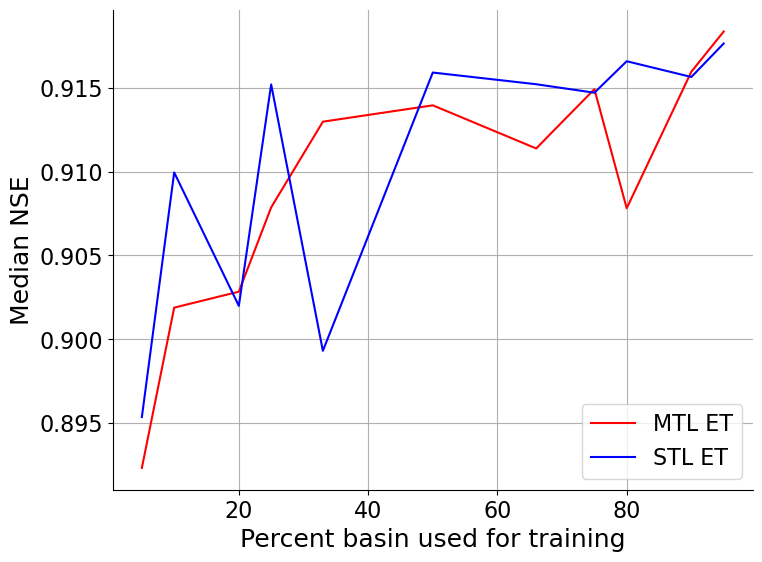

In [18]:
mtlet_temporal_medians = mean_of_medians(mtlet_temporal_metric_lst)
stlet_temporal_medians = mean_of_medians(stlet_temporal_metric_lst)

plot_simple_lines(
    [x_percents, x_percents],
    [mtlet_temporal_medians, stlet_temporal_medians],
    legends=["MTL ET", "STL ET"],
    x_str=xlabel,
    y_str=ylabel,
)
plt.savefig(
    os.path.join(figure_dir, "scale_et_temporal.png"), dpi=600, bbox_inches="tight"
)

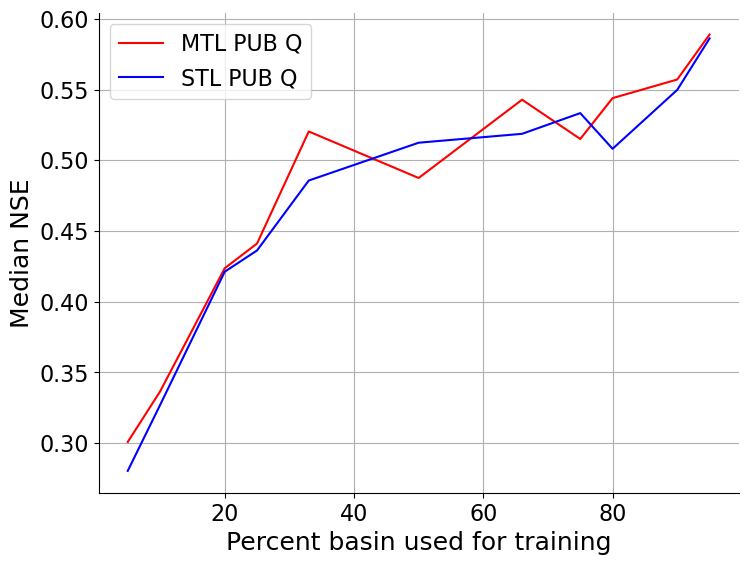

In [19]:
mtlq_spatial_medians = mean_of_medians(mtlq_spatial_metric_lst)
stlq_spatial_medians = mean_of_medians(stlq_spatial_metric_lst)

plot_simple_lines(
    [x_percents, x_percents],
    [mtlq_spatial_medians, stlq_spatial_medians],
    legends=["MTL PUB Q", "STL PUB Q"],
    x_str=xlabel,
    y_str=ylabel,
)
plt.savefig(
    os.path.join(figure_dir, "scale_q_spatial.png"), dpi=600, bbox_inches="tight"
)

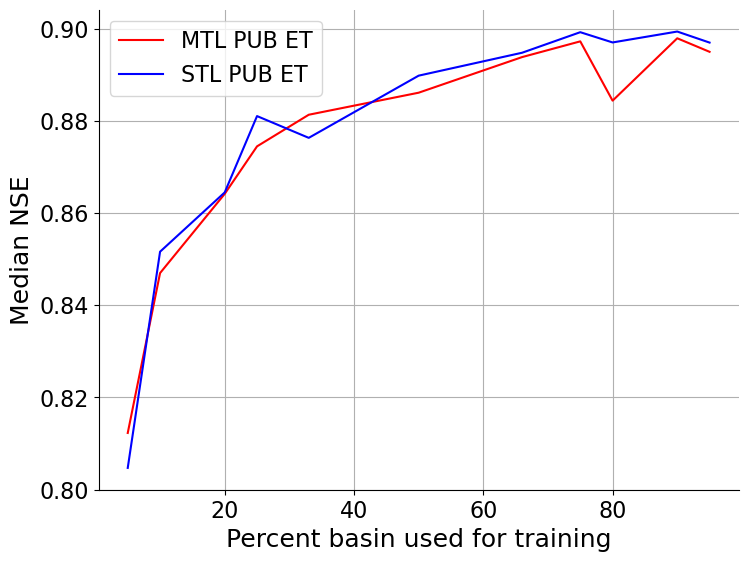

In [20]:
mtlet_spatial_medians = mean_of_medians(mtlet_spatial_metric_lst)
stlet_spatial_medians = mean_of_medians(stlet_spatial_metric_lst)

plot_simple_lines(
    [x_percents, x_percents],
    [mtlet_spatial_medians, stlet_spatial_medians],
    legends=["MTL PUB ET", "STL PUB ET"],
    x_str=xlabel,
    y_str=ylabel,
)
plt.savefig(
    os.path.join(figure_dir, "scale_et_spatial.png"), dpi=600, bbox_inches="tight"
)

Try to plot the scaling curves of temporal and spatial generalization of streamflow (evapotranspiration) in one figure.

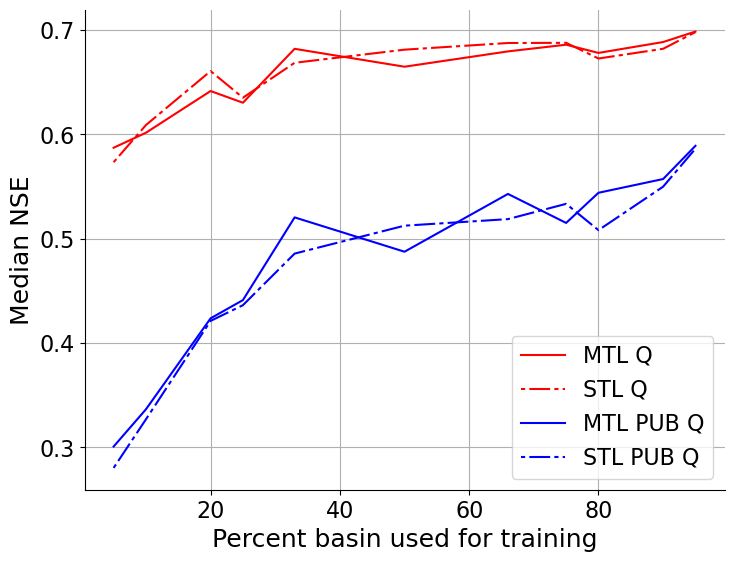

In [23]:
plot_simple_lines(
    [x_percents, x_percents, x_percents, x_percents],
    [
        mtlq_temporal_medians,
        stlq_temporal_medians,
        mtlq_spatial_medians,
        stlq_spatial_medians,
    ],
    legends=["MTL Q", "STL Q", "MTL PUB Q", "STL PUB Q"],
    x_str=xlabel,
    y_str=ylabel,
    dash_lines=[False, True, False, True],
    colors="rrbb",
)
plt.savefig(os.path.join(figure_dir, "scale_q.png"), dpi=600, bbox_inches="tight")


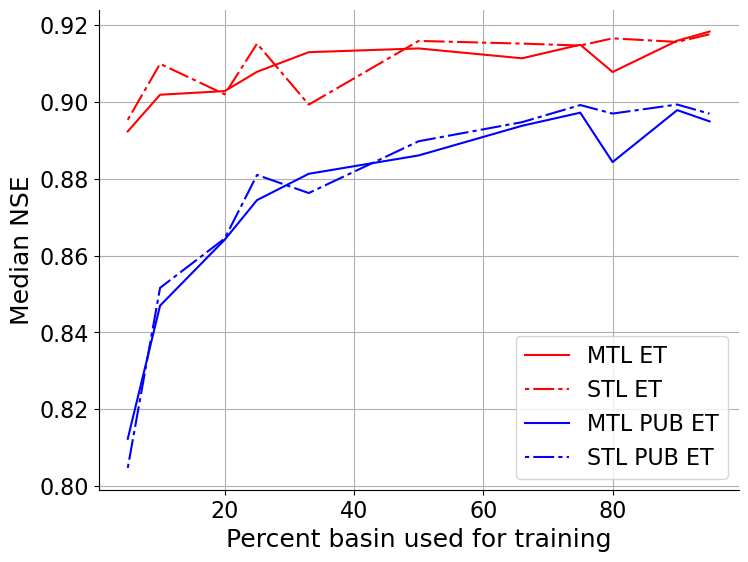

In [24]:
plot_simple_lines(
    [x_percents, x_percents, x_percents, x_percents],
    [
        mtlet_temporal_medians,
        stlet_temporal_medians,
        mtlet_spatial_medians,
        stlet_spatial_medians,
    ],
    legends=["MTL ET", "STL ET", "MTL PUB ET", "STL PUB ET"],
    x_str=xlabel,
    y_str=ylabel,
    dash_lines=[False, True, False, True],
    colors="rrbb",
)
plt.savefig(os.path.join(figure_dir, "scale_et.png"), dpi=600, bbox_inches="tight")
